In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

<h1> Load Dataset </h1>

In [2]:
## CSV from: https://www.kaggle.com/code/salikhussaini49/read-data-from-directory
df = pd.read_csv('data/dataset.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [3]:
df.head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072


In [4]:
df.describe()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
count,1.552210e+06,1.398811e+06,1.349474e+06,525226.000000,1.325945e+06,1.358940e+06,1.065656e+06,1.313875e+06,57636.000000,84145.000000,...,10242.000000,92209.000000,1.552210e+06,1.552210e+06,940250.000000,940250.000000,1.552202e+06,1.552210e+06,1.552210e+06,1.552210e+06
mean,2.549274e+01,8.458144e+01,9.719395e+01,36.977228,1.237505e+02,8.240010e+01,6.383056e+01,1.872650e+01,32.957657,-0.689919,...,287.385706,196.013911,6.200947e+01,5.592690e-01,0.496571,0.503429,-5.612512e+01,2.699499e+01,1.798468e-02,5.920148e+04
std,2.888256e+01,1.732524e+01,2.936924e+00,0.770014,2.323156e+01,1.634175e+01,1.395601e+01,5.098194e+00,7.951662,4.294297,...,153.002908,103.635366,1.638622e+01,4.964749e-01,0.499989,0.499989,1.622569e+02,2.900542e+01,1.328956e-01,5.024819e+04
min,0.000000e+00,2.000000e+01,2.000000e+01,20.900000,2.000000e+01,2.000000e+01,2.000000e+01,1.000000e+00,10.000000,-32.000000,...,34.000000,1.000000,1.400000e+01,0.000000e+00,0.000000,0.000000,-5.366860e+03,1.000000e+00,0.000000e+00,1.000000e+00
25%,9.000000e+00,7.200000e+01,9.600000e+01,36.500000,1.070000e+02,7.100000e+01,5.400000e+01,1.500000e+01,28.000000,-3.000000,...,184.000000,126.000000,5.168000e+01,0.000000e+00,0.000000,0.000000,-4.705000e+01,1.100000e+01,0.000000e+00,9.990000e+03
50%,1.900000e+01,8.350000e+01,9.800000e+01,37.000000,1.210000e+02,8.000000e+01,6.200000e+01,1.800000e+01,33.000000,0.000000,...,250.000000,181.000000,6.400000e+01,1.000000e+00,0.000000,1.000000,-6.030000e+00,2.100000e+01,0.000000e+00,1.996500e+04
75%,3.300000e+01,9.550000e+01,9.950000e+01,37.500000,1.380000e+02,9.200000e+01,7.200000e+01,2.150000e+01,38.000000,1.000000,...,349.000000,244.000000,7.400000e+01,1.000000e+00,1.000000,1.000000,-4.000000e-02,3.400000e+01,0.000000e+00,1.098780e+05
max,3.350000e+02,2.800000e+02,1.000000e+02,50.000000,3.000000e+02,3.000000e+02,3.000000e+02,1.000000e+02,100.000000,100.000000,...,1760.000000,2322.000000,1.000000e+02,1.000000e+00,1.000000,1.000000,2.399000e+01,3.360000e+02,1.000000e+00,1.200000e+05


<h1> Pre-processing </h1>

In [5]:
"""Méthode qui permet de fill les NaN avec une méthode qui s'appel le ForwardFill
et qui fait aussi du Backward fill"""

def impute_missing_vals(df, attributes):
    df_clean = df.copy()
    for att in attributes:
        if df_clean[att].isnull().sum() == len(df_clean):
            df_clean[att] = df_clean[att].fillna(0) # On remplie les cases par des 0
        elif df_clean[att].isnull().sum() == len(df_clean) - 1:
            df_clean[att] = df_clean[att].ffill().bfill() # On remplie les cases à l'aide d'un Forward Fill et d'un Backward Fill
        else:
            df_clean[att] = df_clean[att].interpolate(method='nearest', limit_direction='both') # On utilise une méthode d'interpolation pour remplir avec des valeurs non nulles.
            df_clean[att] = df_clean[att].ffill().bfill()
    
    return df_clean

In [6]:
df = impute_missing_vals(df, df.columns)

In [7]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
scaled_data = min_max_scaler.fit_transform(df.loc[:, df.columns != 'Patient_ID'].to_numpy())
df.loc[:, df.columns != 'Patient_ID'] = scaled_data

In [8]:
df.head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0.000000,0.173077,1.0,0.51134,0.389286,0.185714,0.175,0.156566,0.266667,0.287879,...,0.395133,0.141749,0.634186,0.0,1.0,0.0,0.995546,0.000000,0.0,17072
1,0.002985,0.173077,1.0,0.51134,0.389286,0.185714,0.175,0.156566,0.266667,0.287879,...,0.395133,0.141749,0.634186,0.0,1.0,0.0,0.995546,0.002985,0.0,17072
2,0.005970,0.223077,1.0,0.51134,0.389286,0.080357,0.175,0.156566,0.266667,0.287879,...,0.395133,0.141749,0.634186,0.0,1.0,0.0,0.995546,0.005970,0.0,17072
3,0.008955,0.203846,1.0,0.51134,0.389286,0.080357,0.175,0.161616,0.266667,0.287879,...,0.395133,0.141749,0.634186,0.0,1.0,0.0,0.995546,0.008955,0.0,17072
4,0.011940,0.192308,1.0,0.51134,0.389286,0.192857,0.175,0.131313,0.266667,0.287879,...,0.395133,0.141749,0.634186,0.0,1.0,0.0,0.995546,0.011940,0.0,17072


In [9]:
df.describe()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
count,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,...,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06,1.552210e+06
mean,7.609774e-02,2.476600e-01,9.644136e-01,5.485283e-01,3.705302e-01,2.239183e-01,1.558019e-01,1.785700e-01,2.616466e-01,2.336406e-01,...,1.562314e-01,8.750250e-02,5.582496e-01,5.592690e-01,4.995200e-01,5.004800e-01,9.851386e-01,7.759699e-02,1.798468e-02,5.920148e+04
std,8.621659e-02,6.673580e-02,3.863969e-02,2.491878e-02,8.290813e-02,5.851399e-02,5.019481e-02,5.185881e-02,8.725367e-02,3.279959e-02,...,9.594310e-02,4.414380e-02,1.905374e-01,4.964749e-01,4.999999e-01,4.999999e-01,3.009855e-02,8.658334e-02,1.328956e-01,5.024819e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,2.686567e-02,2.000000e-01,9.500000e-01,5.326460e-01,3.107143e-01,1.821429e-01,1.214286e-01,1.464646e-01,2.555556e-01,2.166667e-01,...,9.096176e-02,5.816458e-02,4.381395e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.868221e-01,2.985075e-02,0.000000e+00,9.990000e+03
50%,5.671642e-02,2.423077e-01,9.750000e-01,5.474227e-01,3.607143e-01,2.178571e-01,1.500000e-01,1.717172e-01,2.666667e-01,2.348485e-01,...,1.297798e-01,8.099957e-02,5.813953e-01,1.000000e+00,0.000000e+00,1.000000e+00,9.944313e-01,5.970149e-02,0.000000e+00,1.996500e+04
75%,9.850746e-02,2.884615e-01,9.875000e-01,5.635739e-01,4.214286e-01,2.571429e-01,1.857143e-01,2.020202e-01,2.666667e-01,2.500000e-01,...,1.952491e-01,1.077122e-01,6.976744e-01,1.000000e+00,1.000000e+00,1.000000e+00,9.955424e-01,9.850746e-02,0.000000e+00,1.098780e+05
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.200000e+05


<h1> TimeSeriesDataset </h1>

In [10]:
# SOURCE: https://stackoverflow.com/questions/57893415/pytorch-dataloader-for-time-series-task

class TimeseriesDataset(torch.utils.data.Dataset):   
    def __init__(self, X, y, seq_len=1):
        self.X = torch.tensor(X,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() - (self.seq_len-1)

    def __getitem__(self, index):
        return (self.X[index:index + self.seq_len], self.y[index + self.seq_len - 1])

In [11]:
x = df.iloc[:,df.columns != 'SepsisLabel'].values
y = df['SepsisLabel'].values

train_dataset = TimeseriesDataset(x, y, seq_len=6)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 256, shuffle = False)

In [12]:
img_batch, _ = next(iter(train_loader))
print(img_batch.min(), img_batch.max())

tensor(0.) tensor(17072.)


<h1> Transfomer </h1>

In [13]:
# SOURCE: https://github.com/LiamMaclean216/Pytorch-Transfomer/blob/master/Transformer.ipynb
from utils import *
from Network import *

#hyperparams
enc_seq_len = 6 # 6 # length of input given to encoder. Can have any integer value.
dec_seq_len = 6 # 2 # length of input given to decoder. Can have any integer value.
output_sequence_length = 1 # 1 # Length of the target sequence, i.e. how many time steps should your forecast cover

input_size = 42 # Multivariate forecasting.
dim_val = 10 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
dim_attn = 5

lr = 0.002
epochs = 5 # 20

n_heads = 4 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number

n_decoder_layers = 3
n_encoder_layers = 3

batch_size = 256

#init network and optimizer
t = Transformer(dim_val, dim_attn, input_size, dec_seq_len, output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads)
optimizer = torch.optim.Adam(t.parameters(), lr=lr)

#keep track of loss for graph
losses = []

<IPython.core.display.Javascript object>


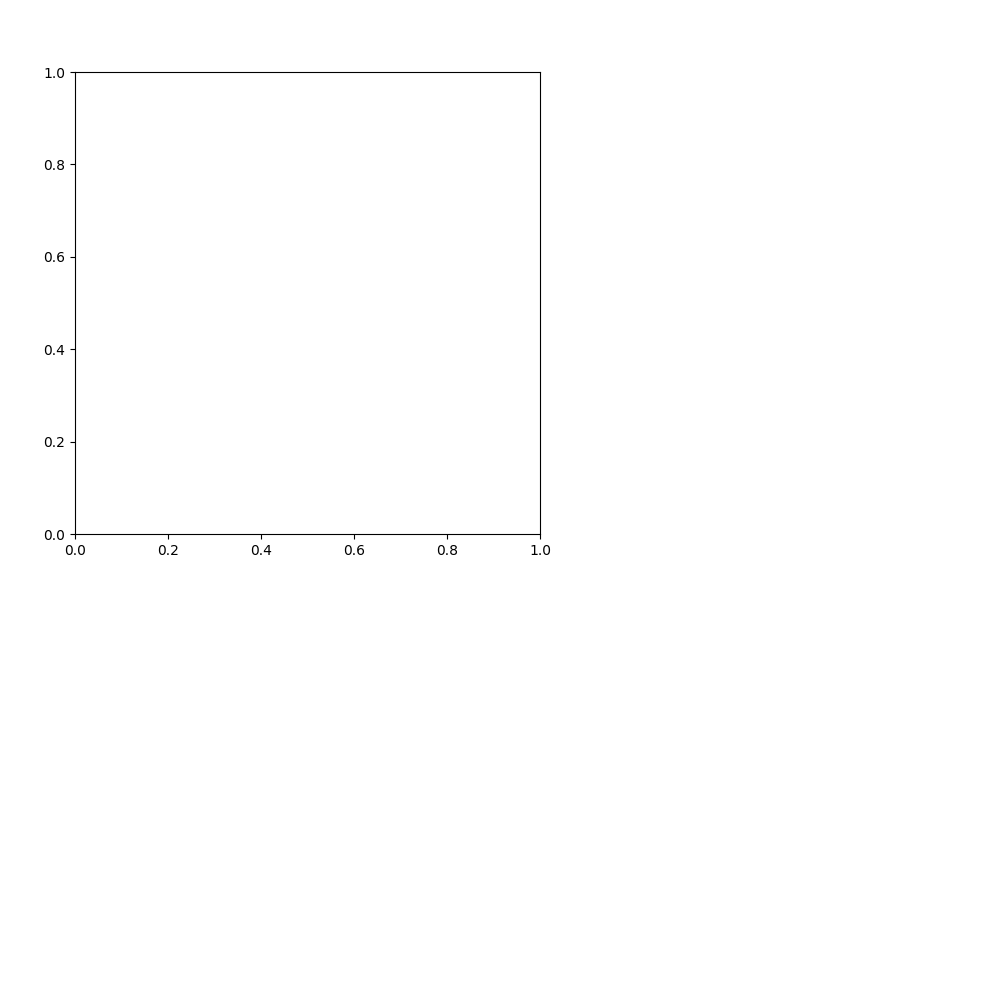

Starting epoch: 0


KeyboardInterrupt: 

In [18]:
#build live matplotlib fig
fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

    
for e in range(epochs):
    print("Starting epoch: " + str(e))
    out = []
    
    #for b in range(-10- enc_seq_len, 10 - enc_seq_len):
    for b in train_loader:
        optimizer.zero_grad()
        #X, Y = get_data(batch_size, enc_seq_len, output_sequence_length)
        X, Y = b
        
        #Forward pass and calculate loss
        net_out = t(X)
        #print(net_out.shape,Y.shape)
        loss = torch.mean((net_out - Y) ** 2)

        #backwards pass
        loss.backward()
        optimizer.step()

        #Track losses and draw rgaph
        out.append([net_out.detach().numpy(), Y])
        losses.append(loss)

        ax.clear()
        ax.plot(losses)
        ax.set_title("Mean Squared Error")
        fig.canvas.draw()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

o = []
x = [torch.sigmoid(torch.arange(-10,-1).float()).unsqueeze(-1).numpy().tolist()]

#Draw graph comparing to sigmoid
for i in range(-10, 10, output_sequence_length):
    o.append([torch.sigmoid(torch.tensor(i).float())])
    q = torch.tensor(x).float()
    
    
    if(output_sequence_length == 1):
        x[0].append([t(q).detach().squeeze().numpy()])
    else:
        for a in t(q).detach().squeeze().numpy():
            x[0].append([a])
            
ax.clear()
#ax.plot(x[0], label='Network output')
ax.plot(o, label='Sigmoid function')
ax.set_title("")
ax.legend(loc='upper left', frameon=False)